<a href="https://colab.research.google.com/github/inspiringsource/fastai/blob/master/COVID_19_Draft_V2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Coronavirus analysis in Switzerland

*Survival analysis

Attempting to create a short visual analysis and estimatiion of actual of Coronavirus cases in Europe, particularly in Switzerland. The primary goal of this notebook is to examin the correlction between the neighboring counties and local outbreak of the COVID-19. 
Resources and inspired by: 



*   https://medium.com/@tomaspueyo/coronavirus-act-today-or-people-will-die-f4d3d9cd99ca
*   https://youtu.be/mCa0JXEwDEk
*   https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases
*   https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru
*   https://www.kaggle.com/thebrownviking20/everything-you-can-do-with-a-time-series
*   https://www.kaggle.com/charel/learn-by-example-rnn-lstm-gru-time-series






This early version... built by relative comparison (change) in neighboring counties to predict the local community spread in Switzerland. I keep a record of the predicted and actual value in the table below:   

# Load data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [0]:
url_con = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_de = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_re = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'


In [0]:
con_raw = pd.read_csv(url_con) #Confirmed cases
de_raw = pd.read_csv(url_de) #Death
re_raw = pd.read_csv(url_re) #Recovered


In [0]:
del con_raw['Lat']
del con_raw['Long']
del con_raw['Province/State']
countries = {}
countries['Data']  = con_raw['Country/Region']
del con_raw['Country/Region']

In [6]:
con_raw.head(1)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20
0,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147


In [0]:
con_raw.columns = pd.to_datetime(con_raw.columns, format="%m/%d/%y")

In [0]:
recent = con_raw.iloc[:, -1:].columns

In [9]:
print('The latest data on the number of confirmed cases by country is from:', recent)

The latest data on the number of confirmed cases by country is from: DatetimeIndex(['2020-03-16'], dtype='datetime64[ns]', freq=None)


In [0]:
con_raw['Country'] = countries['Data']

In [11]:
con_raw.head(1)

,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,Country
0,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,Thailand


In [12]:
con_raw.index

RangeIndex(start=0, stop=463, step=1)

In [0]:
dates = con_raw.iloc[:, :-1].columns

In [14]:
length = len(con_raw.iloc[:, :-1].columns) #length not including Country column
print('The total number of days in the dataset:', length)

The total number of days in the dataset: 55


In [15]:
series1=con_raw
type(series1)
pd.core.series.Series

pandas.core.series.Series

In [16]:
series1.head(1)

,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,Country
0,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,Thailand


In [17]:
series1.columns.values

array([Timestamp('2020-01-22 00:00:00'), Timestamp('2020-01-23 00:00:00'),
       Timestamp('2020-01-24 00:00:00'), Timestamp('2020-01-25 00:00:00'),
       Timestamp('2020-01-26 00:00:00'), Timestamp('2020-01-27 00:00:00'),
       Timestamp('2020-01-28 00:00:00'), Timestamp('2020-01-29 00:00:00'),
       Timestamp('2020-01-30 00:00:00'), Timestamp('2020-01-31 00:00:00'),
       Timestamp('2020-02-01 00:00:00'), Timestamp('2020-02-02 00:00:00'),
       Timestamp('2020-02-03 00:00:00'), Timestamp('2020-02-04 00:00:00'),
       Timestamp('2020-02-05 00:00:00'), Timestamp('2020-02-06 00:00:00'),
       Timestamp('2020-02-07 00:00:00'), Timestamp('2020-02-08 00:00:00'),
       Timestamp('2020-02-09 00:00:00'), Timestamp('2020-02-10 00:00:00'),
       Timestamp('2020-02-11 00:00:00'), Timestamp('2020-02-12 00:00:00'),
       Timestamp('2020-02-13 00:00:00'), Timestamp('2020-02-14 00:00:00'),
       Timestamp('2020-02-15 00:00:00'), Timestamp('2020-02-16 00:00:00'),
       Timestamp('2020-02

In [18]:
#table to series by country
#values= series1.iloc[:, :-1].columns, 

thetable= series1.pivot_table(columns='Country')
thetable.tail()

Country,Afghanistan,Albania,Algeria,Andorra,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Central African Republic,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Cruise Ship,Cuba,Cyprus,Czechia,Denmark,...,Republic of the Congo,Reunion,Romania,Russia,Rwanda,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia,Slovenia,Somalia,South Africa,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Taiwan*,Tanzania,Thailand,The Bahamas,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,occupied Palestinian territory
2020-03-12 00:00:00,7.0,23.0,24.0,1.0,0.0,19.0,4.0,0.0,14.222222,302.0,11.0,195.0,3.0,12.0,314.0,0.0,1.0,2.0,11.0,52.0,11.0,7.0,2.0,3.0,2.0,10.636364,0.0,23.0,2452.484848,9.0,0.0,1.0,22.0,1.0,19.0,696.0,3.0,6.0,94.0,308.5,...,0.0,1.0,49.0,28.0,0.0,0.0,0.0,69.0,45.0,4.0,19.0,0.0,178.0,16.0,89.0,0.0,17.0,2277.0,2.0,0.0,0.0,599.0,652.0,49.0,0.0,70.0,0.0,1.0,0.0,7.0,1.0,6.732794,1.0,85.0,114.75,0.0,0.0,0.0,39.0,0.0
2020-03-13 00:00:00,7.0,33.0,26.0,1.0,1.0,31.0,8.0,2.0,22.222222,504.0,15.0,189.0,3.0,27.0,559.0,0.0,1.0,3.0,13.0,151.0,37.0,23.0,2.0,5.0,2.0,17.545455,0.0,43.0,2452.878788,13.0,0.0,2.0,23.0,1.0,32.0,696.0,4.0,14.0,141.0,402.0,...,0.0,5.0,89.0,45.0,0.0,0.0,0.0,80.0,86.0,10.0,35.0,0.0,200.0,32.0,141.0,0.0,24.0,5232.0,6.0,1.0,0.0,814.0,1139.0,50.0,0.0,75.0,0.0,1.0,0.0,16.0,5.0,8.821862,3.0,85.0,200.50,0.0,0.0,0.0,47.0,0.0
2020-03-14 00:00:00,11.0,38.0,37.0,1.0,1.0,34.0,18.0,2.0,27.777778,655.0,15.0,210.0,3.0,27.0,689.0,0.0,1.0,10.0,18.0,151.0,40.0,41.0,2.0,7.0,2.0,18.000000,0.0,61.0,2453.848485,22.0,0.0,2.0,26.0,1.0,38.0,696.0,4.0,26.0,189.0,418.0,...,0.0,6.0,123.0,59.0,1.0,1.0,1.0,80.0,103.0,10.0,46.0,2.0,212.0,44.0,181.0,0.0,38.0,6391.0,10.0,1.0,1.0,961.0,1359.0,53.0,0.0,82.0,0.0,1.0,2.0,18.0,5.0,11.040486,3.0,85.0,286.00,4.0,0.0,2.0,53.0,0.0
2020-03-15 00:00:00,16.0,42.0,48.0,1.0,1.0,45.0,26.0,2.0,33.000000,860.0,23.0,214.0,5.0,27.0,886.0,0.0,1.0,10.0,24.0,162.0,50.0,51.0,3.0,7.0,2.0,22.909091,1.0,74.0,2454.636364,34.0,1.0,2.0,27.0,1.0,49.0,696.0,4.0,26.0,253.0,437.5,...,0.0,7.0,131.0,63.0,1.0,2.0,1.0,101.0,103.0,24.0,48.0,2.0,226.0,54.0,219.0,0.0,51.0,7798.0,18.0,1.0,1.0,1022.0,2200.0,59.0,0.0,114.0,0.0,1.0,2.0,18.0,6.0,14.165992,3.0,98.0,286.25,4.0,1.0,10.0,56.0,0.0
2020-03-16 00:00:00,21.0,51.0,54.0,2.0,1.0,56.0,52.0,2.0,41.888889,1018.0,15.0,214.0,8.0,36.0,1058.0,1.0,1.0,11.0,25.0,200.0,54.0,52.0,15.0,7.0,4.0,37.727273,1.0,155.0,2455.545455,54.0,1.0,2.0,35.0,1.0,57.0,696.0,4.0,33.0,298.0,466.0,...,1.0,9.0,158.0,90.0,5.0,2.0,1.0,109.0,118.0,24.0,55.0,3.0,243.0,63.0,253.0,1.0,62.0,9942.0,28.0,1.0,1.0,1103.0,2200.0,67.0,1.0,147.0,1.0,1.0,4.0,20.0,18.0,18.753036,7.0,98.0,387.75,8.0,6.0,17.0,61.0,0.0


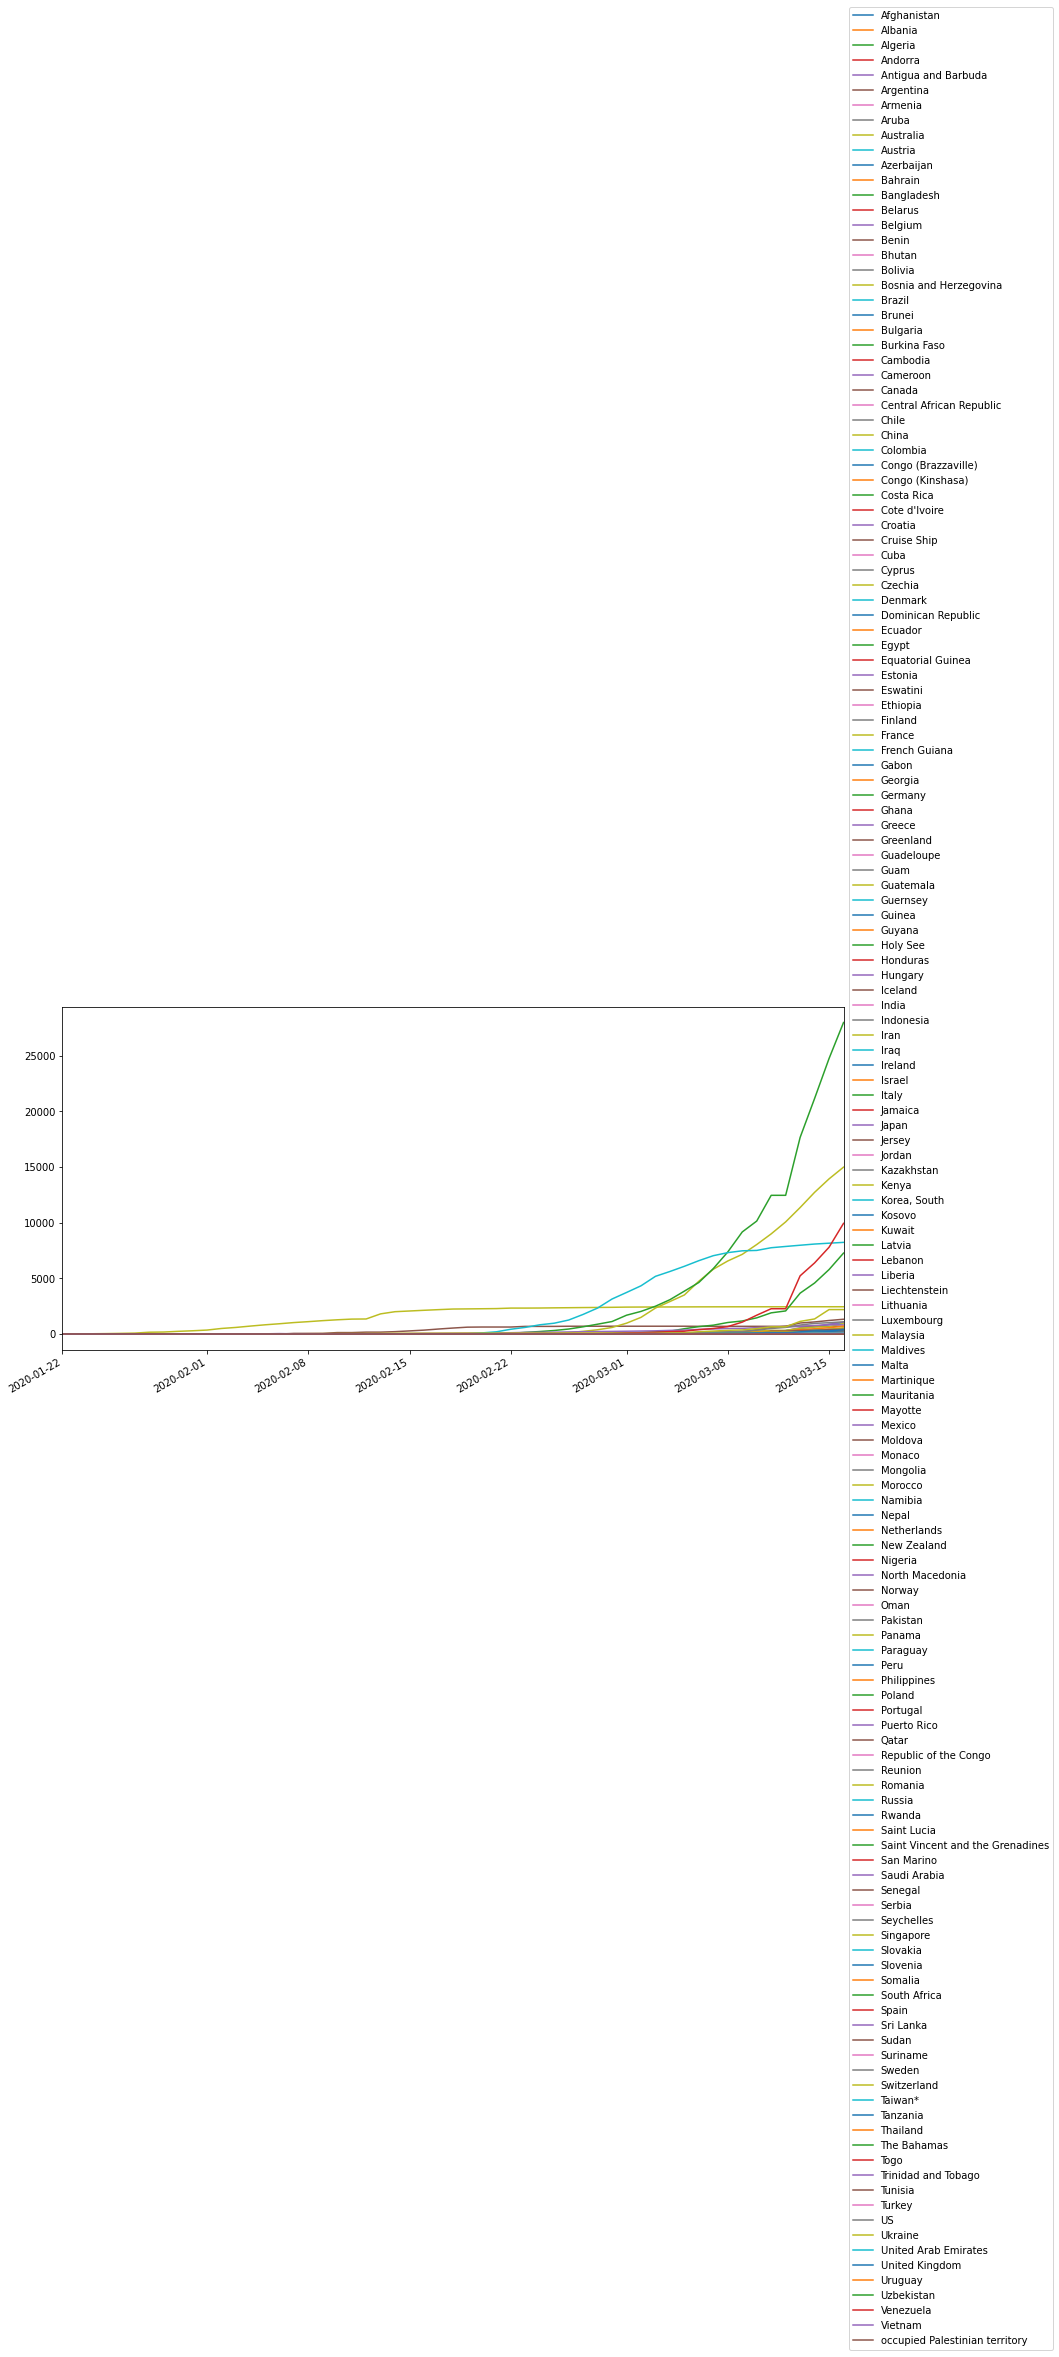

In [19]:
thetable.plot(figsize=(14,7)).legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [0]:
#Let us focus on Switzerland and its neighboring counties. Particularly:
#'France', 'Italy', 'Austria', 'Germany', 'Liechtenstein', 'Switzerland'
#https://www.geeksforgeeks.org/how-to-drop-one-or-multiple-columns-in-pandas-dataframe/

# Switzerland and neighboring countries (Central Europe):


In [0]:
central = thetable.loc[: ,['France', 'Italy', 'Austria', 'Germany', 'Liechtenstein', 'Switzerland']]

In [21]:
central.head()

Country,France,Italy,Austria,Germany,Liechtenstein,Switzerland
2020-01-22 00:00:00,0.000000,0.0,0.0,0.0,0.0,0.0
2020-01-23 00:00:00,0.000000,0.0,0.0,0.0,0.0,0.0
2020-01-24 00:00:00,0.285714,0.0,0.0,0.0,0.0,0.0
2020-01-25 00:00:00,0.428571,0.0,0.0,0.0,0.0,0.0
2020-01-26 00:00:00,0.428571,0.0,0.0,0.0,0.0,0.0


In [0]:
central.index.names = ['Date']

In [0]:
#central.rename(columns={ central.columns[1]: "Date" }, inplace = True)

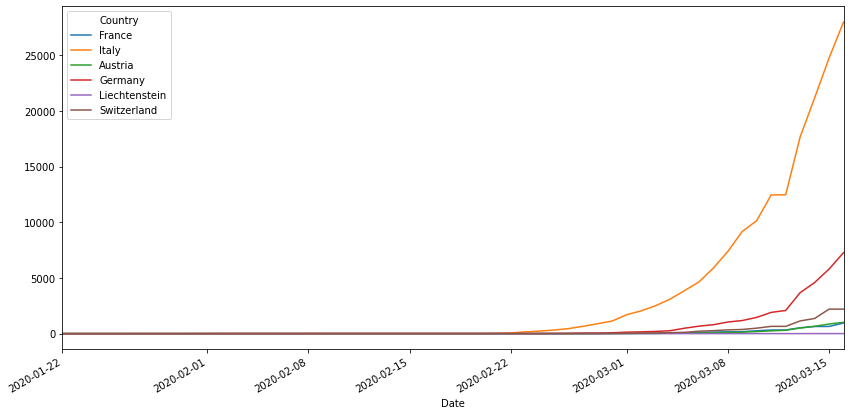

In [23]:
central.plot(figsize=(14,7))

# Main data to CSV

In [0]:
central.to_csv('main_table.csv')

In [25]:
# Let's get the stock data
dataset = pd.read_csv('/content/main_table.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,France,Italy,Austria,Germany,Liechtenstein,Switzerland
Date,,,,,,
2020-01-22,0.000000,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.000000,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.285714,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.428571,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.428571,0.0,0.0,0.0,0.0,0.0


In [0]:
cen_table = central.T

In [27]:
cen_table

Date,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
France,0.0,0.0,0.285714,0.428571,0.428571,0.428571,0.571429,0.714286,0.714286,0.714286,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429,1.714286,1.714286,1.714286,1.714286,1.714286,1.714286,1.714286,1.714286,1.714286,1.714286,2.0,2.571429,5.428571,8.142857,14.285714,18.571429,27.285714,29.142857,41.142857,54.285714,93.714286,136.714286,162.0,173.857143,256.0,327.0,327.0,524.571429,640.0,644.714286,950.0
Italy,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,62.000000,155.000000,229.000000,322.0,453.000000,655.000000,888.000000,1128.000000,1694.000000,2036.000000,2502.000000,3089.000000,3858.000000,4636.000000,5883.000000,7375.0,9172.000000,10149.0,12462.0,12462.0,17660.000000,21157.0,24747.000000,27980.0
Austria,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,2.000000,3.000000,3.000000,9.000000,14.000000,18.000000,21.000000,29.000000,41.000000,55.000000,79.000000,104.0,131.000000,182.0,246.0,302.0,504.000000,655.0,860.000000,1018.0
Germany,0.0,0.0,0.000000,0.000000,0.000000,1.000000,4.000000,4.000000,4.000000,5.000000,8.000000,10.000000,12.000000,12.000000,12.000000,12.000000,13.000000,13.000000,14.000000,14.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,17.0,27.000000,46.000000,48.000000,79.000000,130.000000,159.000000,196.000000,262.000000,482.000000,670.000000,799.000000,1040.0,1176.000000,1457.0,1908.0,2078.0,3675.000000,4585.0,5795.000000,7272.0
Liechtenstein,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.000000,4.0,4.000000,4.0
Switzerland,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,8.000000,8.000000,18.000

# Visualizing 
*old name = Convert dates to Pandas datetime

In [0]:
cen_table.columns = pd.to_datetime(cen_table.columns, format="%m/%d/%y")

In [0]:
cen_table

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
France,0.0,0.0,0.4,0.6,0.6,0.6,0.8,1.0,1.0,1.0,1.2,1.2,1.2,1.2,1.2,1.2,1.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.8,3.6,7.6,11.4,20.0,26.0,38.2,40.8,57.6,76.0,131.2,190.4,225.8,242.4,357.4,456.8,456.8,733.4,896.0
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,20.0,62.0,155.0,229.0,322.0,453.0,655.0,888.0,1128.0,1694.0,2036.0,2502.0,3089.0,3858.0,4636.0,5883.0,7375.0,9172.0,10149.0,12462.0,12462.0,17660.0,21157.0
Austria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,9.0,14.0,18.0,21.0,29.0,41.0,55.0,79.0,104.0,131.0,182.0,246.0,302.0,504.0,655.0
Germany,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,5.0,8.0,10.0,12.0,12.0,12.0,12.0,13.0,13.0,14.0,14.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,17.0,27.0,46.0,48.0,79.0,130.0,159.0,196.0,262.0,482.0,670.0,799.0,1040.0,1176.0,1457.0,1908.0,2078.0,3675.0,4585.0
Liechtenstein,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,8.0,18.0,27.0,42.0,56.0,90.0,114.0,214.0,268.0,337.0,374.0,491.0,652.0,652.0,1139.0,1359.0


# To CSV

In [0]:
#save as our main dataframe for later use
cen_table.to_csv('df.csv', index=True)

Italy which is the scene of a major and early coronavirus outbreak is a significant outlier.
To improve sight we excluded them from the next chart.

In [0]:
focus = cen_table.loc[['France', 'Austria', 'Germany', 'Liechtenstein', 'Switzerland'], :]

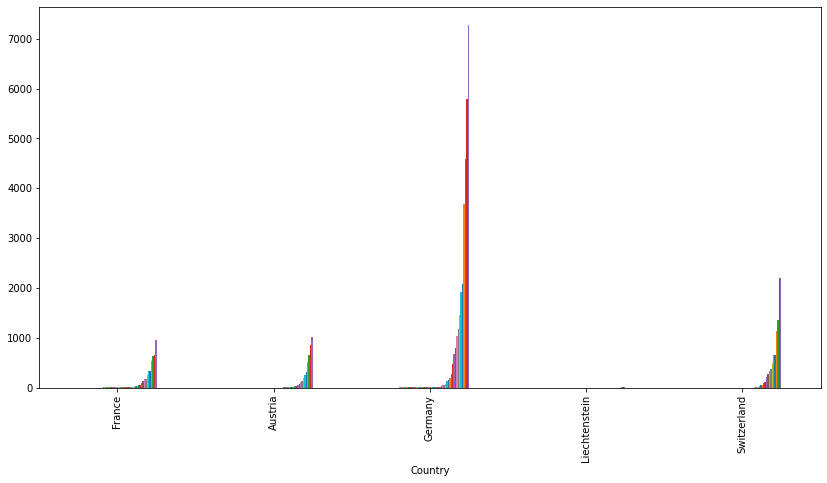

In [30]:
focus.plot.bar(figsize=(14,7), legend=False)

In [31]:
focus.loc[['Germany', 'Switzerland'], :] != 0

Date,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Germany,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
Switzerland,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [0]:
focus = cen_table.loc[['France', 'Austria', 'Germany', 'Liechtenstein', 'Switzerland'], :]

In [0]:
focus = cen_table.loc[['France', 'Austria', 'Germany', 'Liechtenstein', 'Switzerland'], :]

For the next table I am going to exclude outliners by country size. France and Germany are approximately 7 - 9 times bigger than Switzerland. And 'Liechtenstein' is a a city state. 'Austria', and 'Switzerland' are very similar, let us compare both.

In [0]:
ffocus = focus.loc[['Austria', 'Switzerland'], :]

In [35]:
ffocus.head()

Date,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Austria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,9.0,14.0,18.0,21.0,29.0,41.0,55.0,79.0,104.0,131.0,182.0,246.0,302.0,504.0,655.0,860.0,1018.0
Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,8.0,18.0,27.0,42.0,56.0,90.0,114.0,214.0,268.0,337.0,374.0,491.0,652.0,652.0,1139.0,1359.0,2200.0,2200.0


Text(0.5, 0, 'Time')

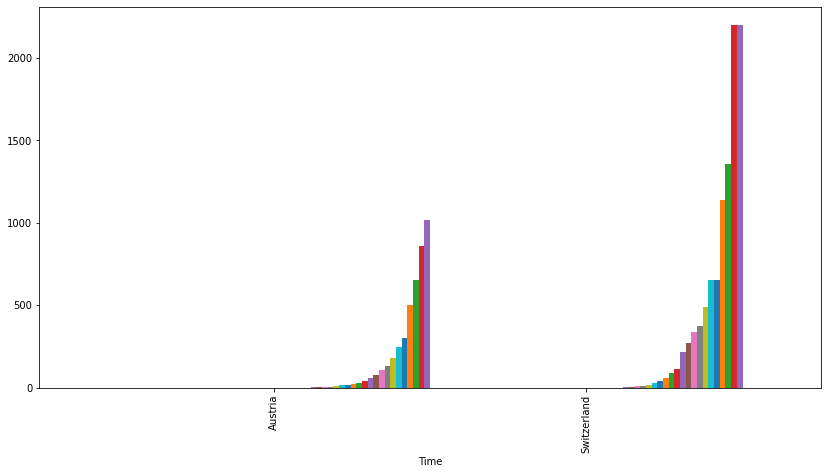

In [36]:
ax = ffocus.plot.bar(legend=False,figsize=(14,7), width=1)
ax.set_xlabel("Time")

# Data pre-processing (*nothing special here*)

In [0]:
cen_table

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
France,0.0,0.0,0.4,0.6,0.6,0.6,0.8,1.0,1.0,1.0,1.2,1.2,1.2,1.2,1.2,1.2,1.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.8,3.6,7.6,11.4,20.0,26.0,38.2,40.8,57.6,76.0,131.2,190.4,225.8,242.4,357.4,456.8,456.8,733.4,896.0
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,20.0,62.0,155.0,229.0,322.0,453.0,655.0,888.0,1128.0,1694.0,2036.0,2502.0,3089.0,3858.0,4636.0,5883.0,7375.0,9172.0,10149.0,12462.0,12462.0,17660.0,21157.0
Austria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,9.0,14.0,18.0,21.0,29.0,41.0,55.0,79.0,104.0,131.0,182.0,246.0,302.0,504.0,655.0
Germany,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,5.0,8.0,10.0,12.0,12.0,12.0,12.0,13.0,13.0,14.0,14.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,17.0,27.0,46.0,48.0,79.0,130.0,159.0,196.0,262.0,482.0,670.0,799.0,1040.0,1176.0,1457.0,1908.0,2078.0,3675.0,4585.0
Liechtenstein,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,8.0,18.0,27.0,42.0,56.0,90.0,114.0,214.0,268.0,337.0,374.0,491.0,652.0,652.0,1139.0,1359.0


In [0]:
cen_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, France to Switzerland
Data columns (total 53 columns):
2020-01-22 00:00:00    6 non-null float64
2020-01-23 00:00:00    6 non-null float64
2020-01-24 00:00:00    6 non-null float64
2020-01-25 00:00:00    6 non-null float64
2020-01-26 00:00:00    6 non-null float64
2020-01-27 00:00:00    6 non-null float64
2020-01-28 00:00:00    6 non-null float64
2020-01-29 00:00:00    6 non-null float64
2020-01-30 00:00:00    6 non-null float64
2020-01-31 00:00:00    6 non-null float64
2020-02-01 00:00:00    6 non-null float64
2020-02-02 00:00:00    6 non-null float64
2020-02-03 00:00:00    6 non-null float64
2020-02-04 00:00:00    6 non-null float64
2020-02-05 00:00:00    6 non-null float64
2020-02-06 00:00:00    6 non-null float64
2020-02-07 00:00:00    6 non-null float64
2020-02-08 00:00:00    6 non-null float64
2020-02-09 00:00:00    6 non-null float64
2020-02-10 00:00:00    6 non-null float64
2020-02-11 00:00:00    6 non-null float64
2020-02

In [0]:
cen_table.columns

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14'],
              dtype='datetime64[ns]', freq=None

In [0]:
central.index

Index([2020-01-22 00:00:00, 2020-01-23 00:00:00, 2020-01-24 00:00:00,
       2020-01-25 00:00:00, 2020-01-26 00:00:00, 2020-01-27 00:00:00,
       2020-01-28 00:00:00, 2020-01-29 00:00:00, 2020-01-30 00:00:00,
       2020-01-31 00:00:00, 2020-02-01 00:00:00, 2020-02-02 00:00:00,
       2020-02-03 00:00:00, 2020-02-04 00:00:00, 2020-02-05 00:00:00,
       2020-02-06 00:00:00, 2020-02-07 00:00:00, 2020-02-08 00:00:00,
       2020-02-09 00:00:00, 2020-02-10 00:00:00, 2020-02-11 00:00:00,
       2020-02-12 00:00:00, 2020-02-13 00:00:00, 2020-02-14 00:00:00,
       2020-02-15 00:00:00, 2020-02-16 00:00:00, 2020-02-17 00:00:00,
       2020-02-18 00:00:00, 2020-02-19 00:00:00, 2020-02-20 00:00:00,
       2020-02-21 00:00:00, 2020-02-22 00:00:00, 2020-02-23 00:00:00,
       2020-02-24 00:00:00, 2020-02-25 00:00:00, 2020-02-26 00:00:00,
       2020-02-27 00:00:00, 2020-02-28 00:00:00, 2020-02-29 00:00:00,
       2020-03-01 00:00:00, 2020-03-02 00:00:00, 2020-03-03 00:00:00,
       2020-03-04 00

In [0]:
cen_table.columns = pd.to_datetime(cen_table.columns, format="%m/%d/%y")

In [0]:
cen_table.tail()

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,20.0,62.0,155.0,229.0,322.0,453.0,655.0,888.0,1128.0,1694.0,2036.0,2502.0,3089.0,3858.0,4636.0,5883.0,7375.0,9172.0,10149.0,12462.0,12462.0,17660.0,21157.0
Austria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,9.0,14.0,18.0,21.0,29.0,41.0,55.0,79.0,104.0,131.0,182.0,246.0,302.0,504.0,655.0
Germany,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,5.0,8.0,10.0,12.0,12.0,12.0,12.0,13.0,13.0,14.0,14.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,17.0,27.0,46.0,48.0,79.0,130.0,159.0,196.0,262.0,482.0,670.0,799.0,1040.0,1176.0,1457.0,1908.0,2078.0,3675.0,4585.0
Liechtenstein,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,8.0,18.0,27.0,42.0,56.0,90.0,114.0,214.0,268.0,337.0,374.0,491.0,652.0,652.0,1139.0,1359.0


In [0]:
cen_table.iloc[:, -1]

Country
France             896.0
Italy            21157.0
Austria            655.0
Germany           4585.0
Liechtenstein        4.0
Switzerland       1359.0
Name: 2020-03-14 00:00:00, dtype: float64

In [0]:
len(cen_table.columns)

53

In [0]:
cen_table

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
France,0.0,0.0,0.4,0.6,0.6,0.6,0.8,1.0,1.0,1.0,1.2,1.2,1.2,1.2,1.2,1.2,1.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.8,3.6,7.6,11.4,20.0,26.0,38.2,40.8,57.6,76.0,131.2,190.4,225.8,242.4,357.4,456.8,456.8,733.4,896.0
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,20.0,62.0,155.0,229.0,322.0,453.0,655.0,888.0,1128.0,1694.0,2036.0,2502.0,3089.0,3858.0,4636.0,5883.0,7375.0,9172.0,10149.0,12462.0,12462.0,17660.0,21157.0
Austria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,9.0,14.0,18.0,21.0,29.0,41.0,55.0,79.0,104.0,131.0,182.0,246.0,302.0,504.0,655.0
Germany,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,5.0,8.0,10.0,12.0,12.0,12.0,12.0,13.0,13.0,14.0,14.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,17.0,27.0,46.0,48.0,79.0,130.0,159.0,196.0,262.0,482.0,670.0,799.0,1040.0,1176.0,1457.0,1908.0,2078.0,3675.0,4585.0
Liechtenstein,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,8.0,18.0,27.0,42.0,56.0,90.0,114.0,214.0,268.0,337.0,374.0,491.0,652.0,652.0,1139.0,1359.0


In [0]:
cen_table.iloc[:, 39:47].columns

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08'],
              dtype='datetime64[ns]', freq=None)

In [0]:
cen_table

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13,2020-03-14
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
France,0.0,0.0,0.4,0.6,0.6,0.6,0.8,1.0,1.0,1.0,1.2,1.2,1.2,1.2,1.2,1.2,1.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.8,3.6,7.6,11.4,20.0,26.0,38.2,40.8,57.6,76.0,131.2,190.4,225.8,242.4,357.4,456.8,456.8,733.4,896.0
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,20.0,62.0,155.0,229.0,322.0,453.0,655.0,888.0,1128.0,1694.0,2036.0,2502.0,3089.0,3858.0,4636.0,5883.0,7375.0,9172.0,10149.0,12462.0,12462.0,17660.0,21157.0
Austria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,9.0,14.0,18.0,21.0,29.0,41.0,55.0,79.0,104.0,131.0,182.0,246.0,302.0,504.0,655.0
Germany,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,5.0,8.0,10.0,12.0,12.0,12.0,12.0,13.0,13.0,14.0,14.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,17.0,27.0,46.0,48.0,79.0,130.0,159.0,196.0,262.0,482.0,670.0,799.0,1040.0,1176.0,1457.0,1908.0,2078.0,3675.0,4585.0
Liechtenstein,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0
Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,8.0,18.0,27.0,42.0,56.0,90.0,114.0,214.0,268.0,337.0,374.0,491.0,652.0,652.0,1139.0,1359.0


In [0]:
cen_table.iloc[:, :-1].columns

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-25',
               '2020-01-26', '2020-01-27', '2020-01-28', '2020-01-29',
               '2020-01-30', '2020-01-31', '2020-02-01', '2020-02-02',
               '2020-02-03', '2020-02-04', '2020-02-05', '2020-02-06',
               '2020-02-07', '2020-02-08', '2020-02-09', '2020-02-10',
               '2020-02-11', '2020-02-12', '2020-02-13', '2020-02-14',
               '2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13'],
              dtype='datetime64[ns]', freq=None)

In [0]:
test_df = cen_table.iloc[:, :-1]

In [0]:
test_df

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
France,0.0,0.0,0.4,0.6,0.6,0.6,0.8,1.0,1.0,1.0,1.2,1.2,1.2,1.2,1.2,1.2,1.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.8,3.6,7.6,11.4,20.0,26.0,38.2,40.8,57.6,76.0,131.2,190.4,225.8,242.4,357.4,456.8,456.8,733.4
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,20.0,62.0,155.0,229.0,322.0,453.0,655.0,888.0,1128.0,1694.0,2036.0,2502.0,3089.0,3858.0,4636.0,5883.0,7375.0,9172.0,10149.0,12462.0,12462.0,17660.0
Austria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,9.0,14.0,18.0,21.0,29.0,41.0,55.0,79.0,104.0,131.0,182.0,246.0,302.0,504.0
Germany,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,5.0,8.0,10.0,12.0,12.0,12.0,12.0,13.0,13.0,14.0,14.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,17.0,27.0,46.0,48.0,79.0,130.0,159.0,196.0,262.0,482.0,670.0,799.0,1040.0,1176.0,1457.0,1908.0,2078.0,3675.0
Liechtenstein,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,8.0,8.0,18.0,27.0,42.0,56.0,90.0,114.0,214.0,268.0,337.0,374.0,491.0,652.0,652.0,1139.0


In [0]:
train_df = cen_table

In [0]:
train_df = train_df[list(train_df.columns[~train_df.columns.duplicated()])]

In [0]:
test_df = test_df[list(test_df.columns[~test_df.columns.duplicated()])]

In [0]:
test_df.head()

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,2020-02-21,2020-02-22,2020-02-23,2020-02-24,2020-02-25,2020-02-26,2020-02-27,2020-02-28,2020-02-29,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,2020-03-11,2020-03-12,2020-03-13
Country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
France,0.0,0.0,0.4,0.6,0.6,0.6,0.8,1.0,1.0,1.0,1.2,1.2,1.2,1.2,1.2,1.2,1.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.4,2.8,3.6,7.6,11.4,20.0,26.0,38.2,40.8,57.6,76.0,131.2,190.4,225.8,242.4,357.4,456.8,456.8,733.4
Italy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,20.0,62.0,155.0,229.0,322.0,453.0,655.0,888.0,1128.0,1694.0,2036.0,2502.0,3089.0,3858.0,4636.0,5883.0,7375.0,9172.0,10149.0,12462.0,12462.0,17660.0
Austria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,3.0,3.0,9.0,14.0,18.0,21.0,29.0,41.0,55.0,79.0,104.0,131.0,182.0,246.0,302.0,504.0
Germany,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,4.0,5.0,8.0,10.0,12.0,12.0,12.0,12.0,13.0,13.0,14.0,14.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,17.0,27.0,46.0,48.0,79.0,130.0,159.0,196.0,262.0,482.0,670.0,799.0,1040.0,1176.0,1457.0,1908.0,2078.0,3675.0
Liechtenstein,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


#  Reading and creating CSVs by countries
https://youtu.be/e2Kga5HeAqk
"I rather be blamed for overreacting"

In [37]:
#Continue here...
df = pd.read_csv('/content/df.csv')
df

,Country,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00
0,France,0.0,0.0,0.285714,0.428571,0.428571,0.428571,0.571429,0.714286,0.714286,0.714286,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,0.857143,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429,1.571429,1.714286,1.714286,1.714286,1.714286,1.714286,1.714286,1.714286,1.714286,1.714286,1.714286,2.0,2.571429,5.428571,8.142857,14.285714,18.571429,27.285714,29.142857,41.142857,54.285714,93.714286,136.714286,162.0,173.857143,256.0,327.0,327.0,524.571429,640.0,644.714286,950.0
1,Italy,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,20.000000,62.000000,155.000000,229.000000,322.0,453.000000,655.000000,888.000000,1128.000000,1694.000000,2036.000000,2502.000000,3089.000000,3858.000000,4636.000000,5883.000000,7375.0,9172.000000,10149.0,12462.0,12462.0,17660.000000,21157.0,24747.000000,27980.0
2,Austria,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,2.000000,3.000000,3.000000,9.000000,14.000000,18.000000,21.000000,29.000000,41.000000,55.000000,79.000000,104.0,131.000000,182.0,246.0,302.0,504.000000,655.0,860.000000,1018.0
3,Germany,0.0,0.0,0.000000,0.000000,0.000000,1.000000,4.000000,4.000000,4.000000,5.000000,8.000000,10.000000,12.000000,12.000000,12.000000,12.000000,13.000000,13.000000,14.000000,14.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,17.0,27.000000,46.000000,48.000000,79.000000,130.000000,159.000000,196.000000,262.000000,482.000000,670.000000,799.000000,1040.0,1176.000000,1457.0,1908.0,2078.0,3675.000000,4585.0,5795.000000,7272.0
4,Liechtenstein,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.0,1.000000,4.0,4.000000,4.0
5,Switzerland,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,8.000000,8.000000,18.000000,27.000000,42.000000,56.000000,90.000000,114

In [0]:
#df.columns = df.columns.str.replace('Country', 'Dates')

In [0]:
#df['Dates']

In [0]:
France = df.iloc[0, :]
Italy = df.iloc[1, :]
Austria = df.iloc[2, :]
Germany = df.iloc[3, :]
#Liechtenstein = df.iloc[4, :]
Switzerland = df.iloc[5, :]

In [0]:
#df.info()

In [39]:
# The number of available data not including Country name:
#version 1
totaldays = len(Switzerland)-1
totaldays

55

In [40]:
#Version 2
len(Switzerland[1:].values)

55

In [0]:
#The actual values:
#Switzerland = Switzerland[1:].values

In [0]:
#Switzerland = tf.convert_to_tensor(Switzerland, dtype=tf.float32)

# The number of total deaths

In [0]:
de_raw.head()

In [0]:
del de_raw['Lat']
del de_raw['Long']
del de_raw['Province/State']
countries = {}
countries['Data']  = de_raw['Country/Region']
del de_raw['Country/Region']

In [48]:
de_raw.head(1)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [0]:
de_raw.columns = pd.to_datetime(de_raw.columns, format="%m/%d/%y")

In [0]:
recent = de_raw.iloc[:, -1:].columns

In [0]:
de_raw['Country'] = countries['Data']

In [52]:
de_raw.head(1)

,2020-01-22 00:00:00,2020-01-23 00:00:00,2020-01-24 00:00:00,2020-01-25 00:00:00,2020-01-26 00:00:00,2020-01-27 00:00:00,2020-01-28 00:00:00,2020-01-29 00:00:00,2020-01-30 00:00:00,2020-01-31 00:00:00,2020-02-01 00:00:00,2020-02-02 00:00:00,2020-02-03 00:00:00,2020-02-04 00:00:00,2020-02-05 00:00:00,2020-02-06 00:00:00,2020-02-07 00:00:00,2020-02-08 00:00:00,2020-02-09 00:00:00,2020-02-10 00:00:00,2020-02-11 00:00:00,2020-02-12 00:00:00,2020-02-13 00:00:00,2020-02-14 00:00:00,2020-02-15 00:00:00,2020-02-16 00:00:00,2020-02-17 00:00:00,2020-02-18 00:00:00,2020-02-19 00:00:00,2020-02-20 00:00:00,2020-02-21 00:00:00,2020-02-22 00:00:00,2020-02-23 00:00:00,2020-02-24 00:00:00,2020-02-25 00:00:00,2020-02-26 00:00:00,2020-02-27 00:00:00,2020-02-28 00:00:00,2020-02-29 00:00:00,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,2020-03-07 00:00:00,2020-03-08 00:00:00,2020-03-09 00:00:00,2020-03-10 00:00:00,2020-03-11 00:00:00,2020-03-12 00:00:00,2020-03-13 00:00:00,2020-03-14 00:00:00,2020-03-15 00:00:00,2020-03-16 00:00:00,Country
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,Thailand


In [53]:
series2=de_raw
type(series2)
pd.core.series.Series

pandas.core.series.Series

In [54]:
detable= series2.pivot_table(columns='Country')
detable.tail()

Country,Afghanistan,Albania,Algeria,Andorra,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,Azerbaijan,Bahrain,Bangladesh,Belarus,Belgium,Benin,Bhutan,Bolivia,Bosnia and Herzegovina,Brazil,Brunei,Bulgaria,Burkina Faso,Cambodia,Cameroon,Canada,Central African Republic,Chile,China,Colombia,Congo (Brazzaville),Congo (Kinshasa),Costa Rica,Cote d'Ivoire,Croatia,Cruise Ship,Cuba,Cyprus,Czechia,Denmark,...,Republic of the Congo,Reunion,Romania,Russia,Rwanda,Saint Lucia,Saint Vincent and the Grenadines,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia,Slovenia,Somalia,South Africa,Spain,Sri Lanka,Sudan,Suriname,Sweden,Switzerland,Taiwan*,Tanzania,Thailand,The Bahamas,Togo,Trinidad and Tobago,Tunisia,Turkey,US,Ukraine,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,occupied Palestinian territory
2020-03-12 00:00:00,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.333333,1.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.090909,0.0,0.0,96.121212,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55.0,0.0,0.0,0.0,1.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.161943,0.0,0.0,2.00,0.0,0.0,0.0,0.0,0.0
2020-03-13 00:00:00,0.0,1.0,2.0,0.0,0.0,2.0,0.0,0.0,0.333333,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.090909,0.0,0.0,96.363636,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.0,0.0,1.0,0.0,1.0,11.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.190283,1.0,0.0,2.00,0.0,0.0,0.0,0.0,0.0
2020-03-14 00:00:00,0.0,1.0,3.0,0.0,0.0,2.0,0.0,0.0,0.333333,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.090909,0.0,0.0,96.757576,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,195.0,0.0,1.0,0.0,2.0,13.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.218623,1.0,0.0,5.25,0.0,0.0,0.0,0.0,0.0
2020-03-15 00:00:00,0.0,1.0,4.0,0.0,0.0,2.0,0.0,0.0,0.333333,1.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.090909,0.0,0.0,97.060606,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,289.0,0.0,1.0,0.0,3.0,14.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.255061,1.0,0.0,5.25,0.0,0.0,0.0,0.0,0.0
2020-03-16 00:00:00,0.0,1.0,4.0,0.0,0.0,2.0,0.0,0.0,0.333333,3.0,1.0,1.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.363636,0.0,0.0,97.484848,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,1.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,342.0,0.0,1.0,0.0,6.0,14.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.344130,1.0,0.0,14.00,0.0,0.0,0.0,0.0,0.0


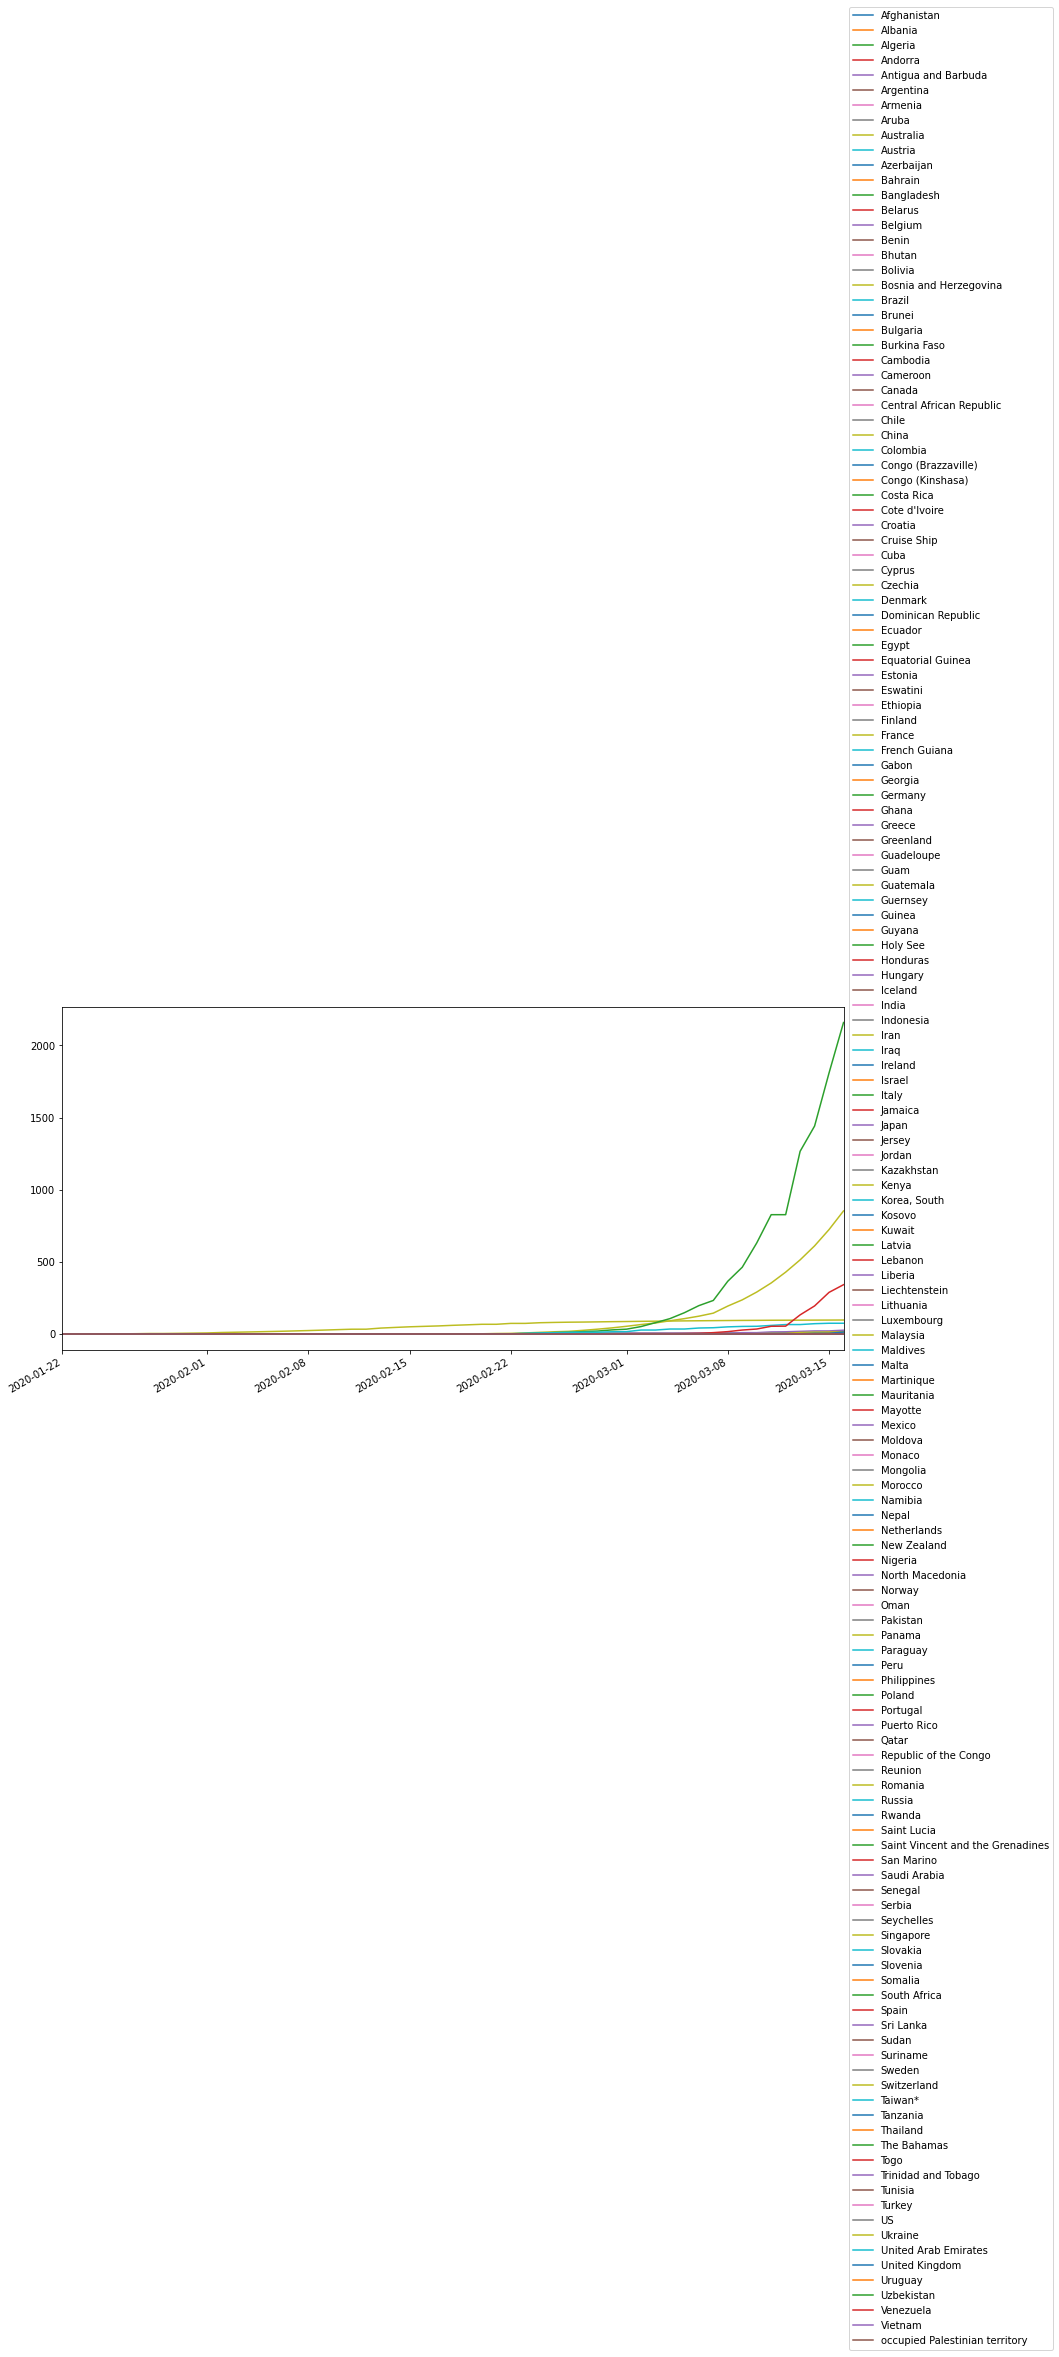

In [55]:
detable.plot(figsize=(14,7)).legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Backwards estimates


In [46]:
Switzerland

Country                Switzerland
2020-01-22 00:00:00              0
2020-01-23 00:00:00              0
2020-01-24 00:00:00              0
2020-01-25 00:00:00              0
2020-01-26 00:00:00              0
2020-01-27 00:00:00              0
2020-01-28 00:00:00              0
2020-01-29 00:00:00              0
2020-01-30 00:00:00              0
2020-01-31 00:00:00              0
2020-02-01 00:00:00              0
2020-02-02 00:00:00              0
2020-02-03 00:00:00              0
2020-02-04 00:00:00              0
2020-02-05 00:00:00              0
2020-02-06 00:00:00              0
2020-02-07 00:00:00              0
2020-02-08 00:00:00              0
2020-02-09 00:00:00              0
2020-02-10 00:00:00              0
2020-02-11 00:00:00              0
2020-02-12 00:00:00              0
2020-02-13 00:00:00              0
2020-02-14 00:00:00              0
2020-02-15 00:00:00              0
2020-02-16 00:00:00              0
2020-02-17 00:00:00              0
2020-02-18 00:00:00 

In [0]:
decentral = detable.loc[: ,['France', 'Italy', 'Austria', 'Germany', 'Liechtenstein', 'Switzerland']]

In [61]:
decentral.columns

Index(['France', 'Italy', 'Austria', 'Germany', 'Liechtenstein',
       'Switzerland'],
      dtype='object', name='Country')

In [0]:
decentral.index.names = ['Date']

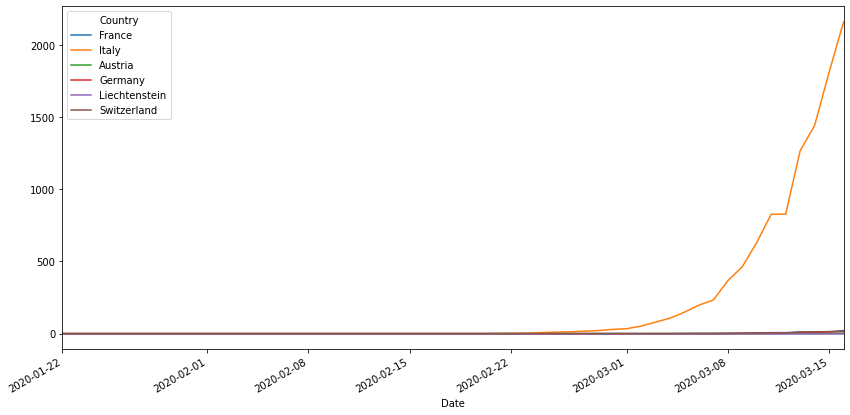

In [59]:
decentral.plot(figsize=(14,7))

In [0]:
dfocus = decentral.loc[:, ['Austria', 'Switzerland']]

In [70]:
dfocus.tail(13)

Country,Austria,Switzerland
Date,,
2020-03-04 00:00:00,0.0,0.0
2020-03-05 00:00:00,0.0,1.0
2020-03-06 00:00:00,0.0,1.0
2020-03-07 00:00:00,0.0,1.0
2020-03-08 00:00:00,0.0,2.0
2020-03-09 00:00:00,0.0,2.0
2020-03-10 00:00:00,0.0,3.0
2020-03-11 00:00:00,0.0,4.0
2020-03-12 00:00:00,1.0,4.0


Text(0.5, 0, 'Time')

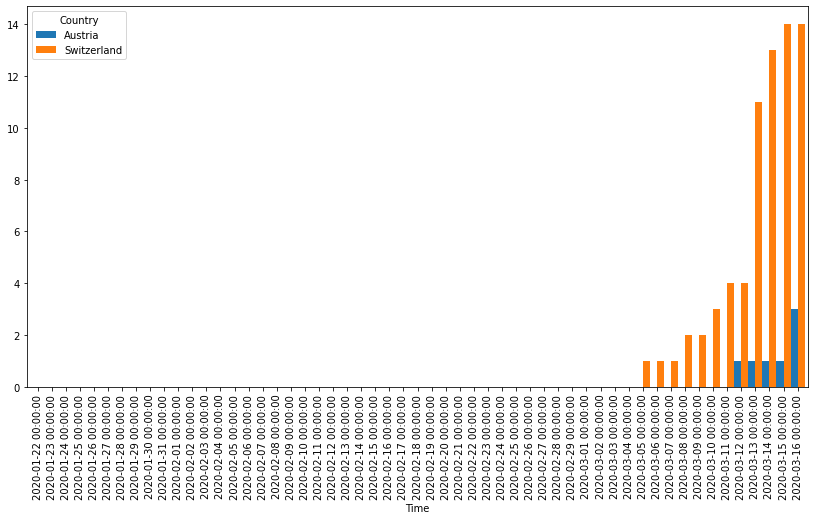

In [67]:
ax = dfocus.plot.bar(legend=True,figsize=(14,7), width=1)
ax.set_xlabel("Time")

Taking taking estimations made on Khan Academy: https://youtu.be/mCa0JXEwDEk

Mortality rate: 1%
Incubation period of 20 days
5 Days to double 

Populating the interactive namespace from numpy and matplotlib


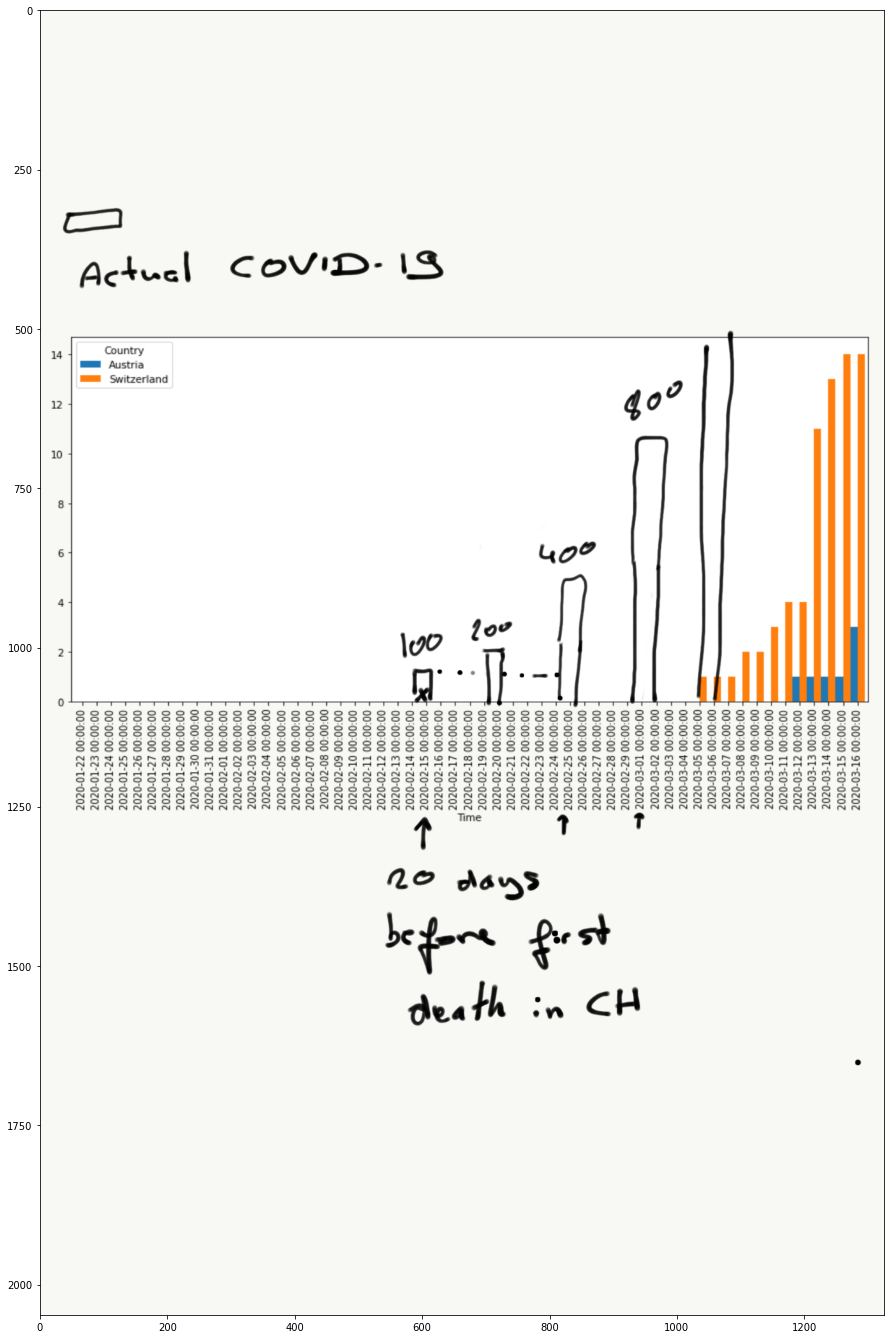

In [86]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('/content/Backwards estimate.png', 0)
imgplot = plt.imshow(img)
S = plt.gcf()
Size = S.get_size_inches()
S.set_size_inches(Size[0]*6, Size[1]*6, forward=True) 
plt.show()

# Time Windows
First, we will train a model to forecast the next step given the previous 20 steps, therefore, we need to create a dataset of 20-step windows for training.

In [0]:
#df.info()

In [0]:
# The number of available data not including Country name:
#version 1
totaldays = len(Switzerland)-1
totaldays

55

In [0]:
#Version 2
len(Switzerland[1:].values)

55

In [0]:
#The actual values:
Switzerland = Switzerland[1:].values

In [0]:
Switzerland = tf.convert_to_tensor(Switzerland, dtype=tf.float32)

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(Switzerland)
for val in dataset:
    print(val.numpy())

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
1.0
1.0
8.0
8.0
18.0
27.0
42.0
56.0
90.0
114.0
214.0
268.0
337.0
374.0
491.0
652.0
652.0
1139.0
1359.0


In [0]:
dataset = tf.data.Dataset.from_tensor_slices(Switzerland)
dataset = dataset.window(5, shift=1)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 1.0 
0.0 0.0 0.0 1.0 1.0 
0.0 0.0 1.0 1.0 8.0 
0.0 1.0 1.0 8.0 8.0 
1.0 1.0 8.0 8.0 18.0 
1.0 8.0 8.0 18.0 27.0 
8.0 8.0 18.0 27.0 42.0 
8.0 18.0 27.0 42.0 56.0 
18.0 27.0 42.0 56.0 90.0 
27.0 42.0 56.0 90.0 114.0 
42.0 56.0 90.0 114.0 214.0 
56.0 90.0 114.0 214.0 268.0 
90.0 114.0 214.0 268.0 337.0 
114.0 214.0 268.0 337.0 374.0 
214.0 268.0 337.0 374

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(Switzerland)
dataset = dataset.window(5, shift=1, drop_remainder=True)
for window_dataset in dataset:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()

0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 1.0 
0.0 0.0 0.0 1.0 1.0 
0.0 0.0 1.0 1.0 8.0 
0.0 1.0 1.0 8.0 8.0 
1.0 1.0 8.0 8.0 18.0 
1.0 8.0 8.0 18.0 27.0 
8.0 8.0 18.0 27.0 42.0 
8.0 18.0 27.0 42.0 56.0 
18.0 27.0 42.0 56.0 90.0 
27.0 42.0 56.0 90.0 114.0 
42.0 56.0 90.0 114.0 214.0 
56.0 90.0 114.0 214.0 268.0 
90.0 114.0 214.0 268.0 337.0 
114.0 214.0 268.0 337.0 374.0 
214.0 268.0 337.0 374

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(Switzerland)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
for window in dataset:
    print(window.numpy())

[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 1. 1.]
[0. 0. 1. 1. 8.]
[0. 1. 1. 8. 8.]
[ 1.  1.  8.  8. 18.]
[ 1.  8.  8. 18. 27.]
[ 8.  8. 18. 27. 42.]
[ 8. 18. 27. 42. 56.]
[18. 27. 42. 56. 90.]
[ 27.  42.  56.  90. 114.]
[ 42.  56.  90. 114. 214.]
[ 56.  90. 114. 214. 268.]
[ 90. 114. 214. 268. 337.]
[114. 214. 268. 337. 374.]
[214. 268. 337. 374. 491.]
[268. 337. 374. 491. 652.]
[337. 374. 491. 652. 652.]
[ 374.  491.  652.  652. 1139.]
[ 491.  652.  652. 1139. 1359.]


In [0]:
dataset = tf.data.Dataset.from_tensor_slices(Switzerland)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
for x, y in dataset:
    print(x.numpy(), y.numpy())

[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [1.]
[0. 0. 0. 1.] [1.]
[0. 0. 1. 1.] [8.]
[0. 1. 1. 8.] [8.]
[1. 1. 8. 8.] [18.]
[ 1.  8.  8. 18.] [27.]
[ 8.  8. 18. 27.] [42.]
[ 8. 18. 27. 42.] [56.]
[18. 27. 42. 56.] [90.]
[27. 42. 56. 90.] [114.]
[ 42.  56.  90. 114.] [214.]
[ 56.  90. 114. 214.] [268.]
[ 90. 114. 214. 268.] [337.]
[114. 214. 268. 337.] [374.]
[214. 268. 337. 374.] [491.]
[268. 337. 374. 491.] [652.]
[337. 374. 491. 652.] [652.]
[374. 491.

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(Switzerland)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
for x, y in dataset:
    print(x.numpy(), y.numpy())

[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 1.] [1.]
[0. 0. 0. 0.] [0.]
[ 8.  8. 18. 27.] [42.]
[0. 1. 1. 8.] [8.]
[0. 0. 0. 0.] [0.]
[18. 27. 42. 56.] [90.]
[ 8. 18. 27. 42.] [56.]
[0. 0. 0. 0.] [0.]
[0. 0. 0. 0.] [1.]
[27. 42. 56. 90.] [114.]
[ 56.  90. 114. 214.] [268.]
[ 1.  8.  8. 18.] [27.]
[214. 268. 337. 374.] [491.]
[1. 1. 8. 8.] [18.]
[0. 0. 0. 0.] [0.]
[114. 214. 268. 337.] [374.]
[ 90. 114. 214. 268.] [337.]
[0. 0. 0. 0.] [0.]
[374. 491. 652. 652.] [1139.]
[337. 374. 491. 652.] [652.]
[ 491.  652.  652. 1139.] [1359.]
[268. 337. 374. 491.] [

In [0]:
dataset = tf.data.Dataset.from_tensor_slices(Switzerland)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)
for x, y in dataset:
    print("x =", x.numpy())
    print("y =", y.numpy())

x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [0.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [0.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [0.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [0.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [0.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [0.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [0.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [0.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [0.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [0.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [0.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [1.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 1.]]
y = [[0.]
 [1.]]
x = [[0. 0. 0. 0.]
 [0. 0. 1. 1.]]
y = [[0.]
 [8.]]
x = [[0. 0. 0. 0.]
 [0. 0. 0. 0.]]
y = [[0.]
 [0.]]
x = [[ 0.  0.  0.  0.]
 [27. 42. 56. 90.]]
y = [[  0.]
 [114.]]
x = [[0. 0. 0. 0.]
 [0. 1. 1. 8.]]
y = [[0.]
 [8.]]
x = [[ 18.  27.  42.  56.]
 [214. 268. 337. 374.]]
y = [[ 90.]
 [491.]]
x = [[ 42.  56.  90. 114.]
 [  8

In [0]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset


# learn-by-example-rnn-lstm-gru-time-series
Source: see above

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "happycloud" # username from the json file
os.environ['KAGGLE_KEY'] = "51a8695dec51c85a992a24e9d1b0e0d8" # key from the json file
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231
!kaggle datasets download -d selfishgene/historical-hourly-weather-data

  0% 0.00/3.03M [00:00<?, ?B/s]
100% 3.03M/3.03M [00:00<00:00, 97.2MB/s]
 75% 9.00M/12.0M [00:00<00:00, 22.5MB/s]
100% 12.0M/12.0M [00:00<00:00, 24.4MB/s]


In [0]:
import zipfile
with zipfile.ZipFile('/content/stock-time-series-20050101-to-20171231.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/stock-time-series-20050101-to-20171231/')

I know I cannot predict stock prices based on historic data, but still the Recurring Neural network examples (RNN or LSTM or GRU, etc) to predict stock prices are appealing, who knows I might discover something:-)

Welcome to my second  notebook on Kaggle. I did record my notes so it might help others in their journey to understand Neural Networks by examples (in this case using Recurring Networks stock predictions.) After seeing many youtube video's and various courses on Neural Networks found the Kaggle Keras course and examples helping me a lot to move from powerpoint understanding to run my own Neural Networks using Keras. Many thanks to this community! The least I could do is to contribute back, hence this notebook.  

Please watch this video about RNN/LSTM/GRU time series prediction, it gives you a good overview, it inspired me to reproduce the steps taken in this notebook:  
https://www.youtube.com/watch?v=2np77NOdnwk  
The code base:  
https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction  
I would like to acknowledge this tutorial for providing ideas and code, learning by example:  
https://www.kaggle.com/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru/notebook  
If you are new to Neural Networks you might want to have a look at my first notebook:  
https://www.kaggle.com/charel/learn-neural-networks-by-example-mnist-digits  


In [0]:
'''try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf'''


In [0]:
import numpy as np # linear algebra
from numpy import newaxis
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


print ('import completed')

import completed


In [0]:
# Enter in how much steps we will enroll the network.
# RNN/LSTM/GRU can be taught patterns over times series as big as the number of times you enrol them, and no bigger (fundamental limitation). 
# So by design these networks are deep/long to catch recurrent patterns.
Enrol_window = 30.0

print ('enrol window set to',Enrol_window )

enrol window set to 30.0


In [0]:
sc = MinMaxScaler(feature_range=(0,1))
def load_data(datasetname, column, seq_len, normalise_window):
    # A support function to help prepare datasets for an RNN/LSTM/GRU
    data = datasetname.loc[:,column]

    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        #result = sc.fit_transform(result)
        result = normalise_windows(result)

    result = np.array(result)

    #Last 10% is used for validation test, first 90% for training
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

def normalise_windows(window_data):
    # A support function to normalize a dataset
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of <prediction_len> steps before shifting prediction run forward by <prediction_len> steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

def plot_results(predicted_data, true_data): 
    fig = plt.figure(facecolor='white') 
    ax = fig.add_subplot(111) 
    ax.plot(true_data, label='True Data') 
    plt.plot(predicted_data, label='Prediction') 
    plt.legend() 
    plt.show() 
    
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

print ('Support functions defined')

Support functions defined


In [0]:
# Let's get the stock data
dataset = pd.read_csv('/content/main_table.csv', index_col='Date', parse_dates=['Date'])
dataset.head()

,France,Italy,Austria,Germany,Liechtenstein,Switzerland
Date,,,,,,
2020-01-22,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-23,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-24,0.4,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.6,0.0,0.0,0.0,0.0,0.0
2020-01-26,0.6,0.0,0.0,0.0,0.0,0.0


In [0]:
# Prepare the dataset, note that the stock price data will be normalized between 0 and 1
# A label is the thing we're predicting
# A feature is an input variable, in this case a stock price
# Selected 'Close' (stock pric at closing) attribute for prices. Let's see what it looks like

feature_train, label_train, feature_test, label_test = load_data(dataset, 'Switzerland', Enrol_window, True)

dataset["Switzerland"][:'2020-03-01'].plot(figsize=(16,4),legend=True)
dataset["Switzerland"]['2020-03-01':].plot(figsize=(16,4),legend=True) # 10% is used for thraining data which is approx 2017 data
plt.legend(['Training set (First 90%, approx before 2017)','Test set (Last 10%, approax 2017 and beyond)'])
plt.title('IBM stock price')
plt.show()



TypeError: ignored

In [0]:
# The same LSTM model I would like to test, lets see if the sinus prediction results can be matched
# Note: replace LSTM with GRU or RNN if you want to try those

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(feature_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation = "linear"))

model.compile(loss='mse', optimizer='adam')

print ('model compiled')



model compiled


In [0]:
#Train the model
model.fit(feature_train, label_train, batch_size=512, epochs=5, validation_data = (feature_test, label_test))


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 2627 samples, validate on 292 samples
Epoch 1/5
2627/2627 [==============================] - 3s 1ms/step - loss: 0.0096 - val_loss: 0.0017
Epoch 2/5
2627/2627 [==============================] - 2s 630us/step - loss: 0.0022 - val_loss: 7.1105e-04
Epoch 3/5
2627/2627 [==============================] - 2s 627us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 4/5
2627/2627 [==============================] - 2s 628us/step - loss: 0.0016 - val_loss: 5.1589e-04
Epoch 5/5
2627/2627 [==============================] - 2s 652us/step - loss: 0.0010 - val_loss: 6.9515e-04


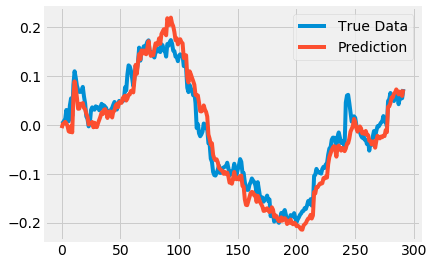

In [0]:
#Let's use the model and predict the stock
predicted_stock_price = model.predict(feature_test)
plot_results(predicted_stock_price,label_test)


Everybody on Kaggle rich! This looks incredible correct, but "if it is to good to be true, it is probably not true".  
Let's step back and actually see what we did. We created a testset of 100 (dependend on how you set the enrol_window) actual datapoints and ask to predict nr 101 (which is probably anhow close to nr 100). And we did so for each point in this graph. Hence the fantastic result, it wasn't that hard (Remember that you are looking at normalised data)

Like the sinewave example we need to predict a new point based on the actual last 100 points, the next point on 99 actual points and 1 prediction, the next point on 98 actuals and 2 predictions, and so forth.   
Lets make some 50 predictions ahead in the future and do this every 50 times to get a bearing how the model predicts

In [0]:
predictions = predict_sequences_multiple(model, feature_test, Enrol_window, 50)
plot_results_multiple(predictions, label_test, 50)


TypeError: ignored

Ouch, can't use that to put some real money on the stock market.  We basically knew already that you cant predict future stock prices on historic data. Pick for example the grey or purple line, it probably learned the stock went down last 100 sequence so it predicts it will go down, what would be a recognizable pattern to predict the trend will break and would go back up again after point 200.  So it is nog recognisable in the historic data, else the algorithem would have found it. Maybe with a richer data set with correleated stocks? Other (News?) items? Etc Anyhow, still a nice learning example which helped me to practice with LSTM (but could also picked GRU or RNN, fw simple code changes in the model)

# Forecasting with an RNN

## Setup

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [0]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    
'''def trend(time, slope=0):
    return slope * time
  '''
'''  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))'''

  
'''def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)'''
  
'''  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level'''
  
  
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(Switzerland) #tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
  
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(Switzerland) # tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [0]:
time = np.arange(4 * 365 + 1) #consider totaldays

'''slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise'''

series= model(time)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

NameError: ignored

In [0]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

TypeError: ignored

## Simple RNN Forecasting

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
  keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.SimpleRNN(100),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1.5e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint", save_best_only=True)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

In [0]:
model = keras.models.load_model("my_checkpoint")

In [0]:
rnn_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

## Sequence-to-Sequence Forecasting

In [0]:
def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 3,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

In [0]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [0]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True,
                         input_shape=[None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [0]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# FastAI
This code was learned from FastAI course by Jeremy Howard: https://forums.fast.ai/t/lesson-4-official-resources-and-updates/30317

Predicting the coronavirus outbreak:

In [0]:
df = pd.read_csv('/content/df.csv')

In [0]:
df.T

In [0]:
df.columns = df.columns.str.replace('3/9/20', 'Target')

In [0]:
df.iloc[:, -1:].columns

In [0]:
df.iloc[:, 0]

In [0]:
df.iloc[:, 0] = df.iloc[:, 0].astype('category')

In [0]:
from fastai import *
from fastai.tabular import *

In [0]:
dep_var = 'Target'
#cat_names = ['Country']
cont_names  = ['1/22/20', '1/23/20', '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20', '1/30/20', '1/31/20', '2/1/20', '2/10/20', '2/11/20', '2/12/20', '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20', '2/19/20', '2/2/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20', '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '2/3/20', '2/4/20', '2/5/20', '2/6/20', '2/7/20', '2/8/20', '2/9/20', '3/1/20', '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20']
procs = [FillMissing, Categorify, Normalize]

In [0]:
''' cat_names=cat_names,'''
test = TabularList.from_df(df.iloc[39:49].copy(), cont_names=cont_names)

In [0]:
'''cat_names=cat_names,''' 
data = (TabularList.from_df(df, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(int(0.2*len(df)))))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch(bs=4))

In [0]:
data.show_batch(rows=10)

In [0]:
learn = tabular_learner(data, layers=[200,100], metrics=accuracy)

In [0]:
learn.fit_one_cycle(1)

In [0]:
train_df.iloc[-1:, -1:]

In [0]:
France = train_df.iloc[0]
France.tail()

In [0]:
learn.predict(France)

In [0]:
#############

In [0]:
series1['Country/Region'].unique()

In [0]:
series1['Country/Region'] = con_raw['Country/Region']

In [0]:
series1

In [0]:
series1.columns

In [0]:
#d = {'1/22/20': 'sum', '1/23/20': 'sum', '1/24/20': 'sum', '1/25/20': 'sum', '1/26/20': 'sum', '1/27/20': 'sum',
           '1/28/20': 'sum', '1/29/20': 'sum', '1/30/20': 'sum', '1/31/20': 'sum', '2/1/20': 'sum', '2/2/20': 'sum',
           '2/3/20': 'sum', '2/4/20': 'sum', '2/5/20': 'sum', '2/6/20': 'sum', '2/7/20': 'sum', '2/8/20': 'sum', '2/9/20': 'sum',
           '2/10/20': 'sum', '2/11/20': 'sum', '2/12/20': 'sum', '2/13/20': 'sum', '2/14/20': 'sum', '2/15/20': 'sum',
           '2/16/20': 'sum', '2/17/20': 'sum', '2/18/20': 'sum', '2/19/20': 'sum', '2/20/20': 'sum', '2/21/20': 'sum',
           '2/22/20': 'sum', '2/23/20': 'sum', '2/24/20': 'sum', '2/25/20': 'sum', '2/26/20': 'sum', '2/27/20': 'sum',
           '2/28/20': 'sum', '2/29/20': 'sum', '3/1/20': 'sum', '3/2/20': 'sum', '3/3/20': 'sum', '3/4/20': 'sum', '3/5/20': 'sum',
           '3/6/20': 'sum', 'Country/Region': 'Mainland China', 'Thailand', 'Japan', 'South Korea', 'Taiwan', 'US', 'Macau', 'Hong Kong', 'Singapore', 'Vietnam', 'France', 'Nepal', 'Malaysia', 'Canada', 'Australia', 'Cambodia', 'Sri Lanka', 'Germany', 'Finland', 'United Arab Emirates', 'Philippines', 'India', 'Italy', 'UK', 'Russia', 'Sweden', 'Spain', 'Belgium', 'Others', 'Egypt', 'Iran', 'Lebanon', 'Iraq', 'Oman', 'Afghanistan', 'Bahrain', 'Kuwait', 'Algeria', 'Croatia', 'Switzerland', 'Austria', 'Israel', 'Pakistan', 'Brazil', 'Georgia', 'Greece', 'North Macedonia', 'Norway', 'Romania', 'Denmark', 'Estonia', 'Netherlands', 'San Marino', 'Belarus', 'Iceland', 'Lithuania', 'Mexico', 'New Zealand', 'Nigeria', 'Ireland', 'Luxembourg', 'Monaco', 'Qatar', 'Ecuador', 'Azerbaijan', 'Czech Republic', 'Armenia', 'Dominican Republic', 'Indonesia', 'Portugal', 'Andorra', 'Latvia', 'Morocco', 'Saudi Arabia', 'Senegal', 'Argentina', 'Chile', 'Jordan', 'Ukraine', 'Saint Barthelemy', 'Hungary', 'Faroe Islands', 'Gibraltar', 'Liechtenstein', 'Poland', 'Tunisia', 'Palestine', 'Bosnia and Herzegovina', 'Slovenia', 'South Africa', 'Bhutan', 'Cameroon', 'Colombia', 'Costa Rica', 'Peru', 'Serbia', 'Slovakia', 'Togo', 'Vatican City', 'French Guiana', 'Malta', 'Martinique'}

In [0]:
#df_new = series1.groupby('Country/Region', as_index=False).aggregate(d).reindex(columns=df.columns)

In [0]:
dates = con_raw.iloc[:, 4:-1]

In [0]:
country  = con_raw.iloc[:, 1]

In [0]:
daily_con = con_raw.iloc[:, 4:-1]
daily_con.plot()
plt.title('Coronavirus Confirmed Cases')
plt.ylabel('Number of Cases')
plt.xlabel('Date')
plt.rcParams['figure.figsize'] = (35.0, 14.0)
plt.legend('',frameon=False)

In [0]:
import matplotlib.pyplot as plt

In [0]:
dates

In [0]:
plt.figure(figsize=(20, 12))
plt.plot(con_raw.iloc[:, 4:-1])
plt.title('# of Coronavirus Cases Over Time', size=30)
plt.xlabel('Time in Days', size=30)
plt.ylabel('# of Cases', size=30)
plt.xticks(rotation=50, size=15)
plt.show()

In [0]:
con_raw.iloc[:, 4:-1].columns

In [0]:
from datetime import datetime

In [0]:
dates = pd.to_datetime(con_raw.iloc[:, 4:-1].columns, format="%m/%d/%y")

In [0]:
dates

In [0]:
#http://www.blog.pythonlibrary.org/2018/06/05/creating-pdfs-with-pyfpdf-and-python/
#!pip install fpdf

In [0]:
#from fpdf import FPDF
#pdf = FPDF()
#pdf.add_page()
#pdf.set_font("Arial", size=12)
#pdf.cell(200, 10, txt="Welcome to Python!", ln=1, align="C")
#pdf.output("report.pdf")

My resource: https://youtu.be/jV24N7SPXEU?t=289

# Intro to Recurrent Neural Networks LSTM | GRU

In [0]:
import os
os.environ['KAGGLE_USERNAME'] = "happycloud" # username from the json file
os.environ['KAGGLE_KEY'] = "51a8695dec51c85a992a24e9d1b0e0d8" # key from the json file
!kaggle datasets download -d szrlee/stock-time-series-20050101-to-20171231
!kaggle datasets download -d selfishgene/historical-hourly-weather-data

In [0]:
import zipfile
with zipfile.ZipFile('/content/stock-time-series-20050101-to-20171231.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/stock-time-series-20050101-to-20171231/')

## Components of LSTMs
So the LSTM cell contains the following components
* Forget Gate “f” ( a neural network with sigmoid)
* Candidate layer “C"(a NN with Tanh)
* Input Gate “I” ( a NN with sigmoid )
* Output Gate “O”( a NN with sigmoid)
* Hidden state “H” ( a vector )
* Memory state “C” ( a vector)

* Inputs to the LSTM cell at any step are X<sub>t</sub> (current input) , H<sub>t-1</sub> (previous hidden state ) and C<sub>t-1</sub> (previous memory state).  
* Outputs from the LSTM cell are H<sub>t</sub> (current hidden state ) and C<sub>t</sub> (current memory state)

## Working of gates in LSTMs
First, LSTM cell takes the previous memory state C<sub>t-1</sub> and does element wise multiplication with forget gate (f) to decide if  present memory state C<sub>t</sub>. If forget gate value is 0 then previous memory state is completely forgotten else f forget gate value is 1 then previous memory state is completely passed to the cell ( Remember f gate gives values between 0 and 1 ).

**C<sub>t</sub> = C<sub>t-1</sub> * f<sub>t</sub>**

Calculating the new memory state: 

**C<sub>t</sub> = C<sub>t</sub> + (I<sub>t</sub> * C\`<sub>t</sub>)**

Now, we calculate the output:

**H<sub>t</sub> = tanh(C<sub>t</sub>)**

### And now we get to the code...
I will use LSTMs for predicting the price of stocks of IBM for the year 2017

In [0]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [0]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real IBM Stock Price')
    plt.plot(predicted, color='blue',label='Predicted IBM Stock Price')
    plt.title('IBM Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('IBM Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [0]:
# First, we get the data
dataset = pd.read_csv('../content/stock-time-series-20050101-to-20171231/IBM_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'])
dataset.tail(30)

In [0]:
# Checking for missing values
training_set = dataset[:'2017-12-01'].iloc[:,1:2].values
test_set = dataset['2017-12-15':].iloc[:,1:2].values

In [0]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2017-12-01'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017-12-15':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('IBM stock price')
plt.show()

In [0]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

In [0]:
# Since LSTMs store long term memory state, we create a data structure with 60 timesteps and 1 output
# So for each element of training set, we have 60 previous training set elements 
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [0]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [0]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=50, return_sequences=True))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=5,batch_size=32)

In [0]:
# Now to get the test set ready in a similar way as the training set.
# The following has been done so forst 60 entires of test set have 60 previous values which is impossible to get unless we take the whole 
# 'High' attribute data for processing
dataset_total = pd.concat((dataset["High"][:'2017-12-01'],dataset["High"]['2017-12-15':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 3:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [0]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(3,5):
    X_test.append(inputs[i-3:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [0]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [0]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

Truth be told. That's one awesome score. 

LSTM is not the only kind of unit that has taken the world of Deep Learning by a storm. We have **Gated Recurrent Units(GRU)**. It's not known, which is better: GRU or LSTM becuase they have comparable performances. GRUs are easier to train than LSTMs.

## Gated Recurrent Units
In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the outpu, .neither they have the output gate.

Source: [Quora](https://www.quora.com/Whats-the-difference-between-LSTM-and-GRU-Why-are-GRU-efficient-to-train)

<img src="https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/11/GRU.png?x31195">

In [0]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=50, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

The current version version uses a dense GRU network with 100 units as opposed to the GRU network with 50 units in previous version

In [0]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,311):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [0]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [0]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

## Sequence Generation
Here, I will generate a sequence using just initial 60 values instead of using last 60 values for every new prediction. **Due to doubts in various comments about predictions making use of test set values, I have decided to include sequence generation.** The above models make use of test set so it is using last 60 true values for predicting the new value(I will call it a benchmark). This is why the error is so low. Strong models can bring similar results like above models for sequences too but they require more than just data which has previous values. In case of stocks, we need to know the sentiments of the market, the movement of other stocks and a lot more. So, don't expect a remotely accurate plot. The error will be great and the best I can do is generate the trend similar to the test set.

I will use GRU model for predictions. You can try this using LSTMs also. I have modified GRU model above to get the best sequence possible. I have run the model four times and two times I got error of around 8 to 9. The worst case had an error of around 11. Let's see what this iterations.

The GRU model in the previous versions is fine too. Just a little tweaking was required to get good sequences. **The main goal of this kernel is to show how to build RNN models. How you predict data and what kind of data you predict is up to you. I can't give you some 100 lines of code where you put the destination of training and test set and get world-class results. That's something you have to do yourself.**

In [0]:
# Preparing sequence data
initial_sequence = X_train[2708,:]
sequence = []
for i in range(251):
    new_prediction = regressorGRU.predict(initial_sequence.reshape(initial_sequence.shape[1],initial_sequence.shape[0],1))
    initial_sequence = initial_sequence[1:]
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0)
    sequence.append(new_prediction)
sequence = sc.inverse_transform(np.array(sequence).reshape(251,1))

In [0]:
# Visualizing the sequence
plot_predictions(test_set,sequence)

In [0]:
# Evaluating the sequence
return_rmse(test_set,sequence)

# GitHub

In [0]:
#!git remote add origin https://github.com/inspiringsource/COVID-19_Forecast.git

In [0]:
#!git push -u origin master